In [12]:
# ==========================================
# SETUP BLOCK 
# ==========================================

import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# ---- Imports from project files ----
sys.path.append(os.path.abspath(".."))
from Helper_funtions import (
    clean_up_subjects,
    calculate_true_false_score,
    calculate_Internet_terms_understanding_score,
    group_internet_understanding
)
from lists import (
    demographic_columns,
    multiple_choice_questions,
    single_choice_questions,
    likert_questions,
    likert_mapping,
    cross_tab_titles_and_colors

)
from answer_categories import question_orders

# ---- General plot style ----
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

# ---- Data loading ----
DATA_FILE = os.path.join("..", "Data", "Fertige Tabelle.xlsx")
df = pd.read_excel(DATA_FILE)
df.columns = df.columns.str.strip()

# Clean up multi-subject columns
for col in ["Most used subjects", "Preferred Subjects", "Least preferred Subjects"]:
    if col in df.columns:
        df = clean_up_subjects(df, col)

# Calculate additional scores
if all(q in df.columns for q in ["True/False_1", "True/False_2"]):
    df = calculate_true_false_score(df)

if any(col.startswith("Internet terms_") for col in df.columns):
    df = calculate_Internet_terms_understanding_score(df)
    df = group_internet_understanding(df)

print("✅ Setup complete – DataFrame loaded and preprocessed")
print(f"Rows: {len(df)}, Columns: {len(df.columns)}")


✅ Setup complete – DataFrame loaded and preprocessed
Rows: 203, Columns: 43


c:\Users\tills\Bachelor-Code\Analyse_Files\Helper_funtions.py:124: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_mapped = df[internet_cols].replace(Internet_terms_mapping)


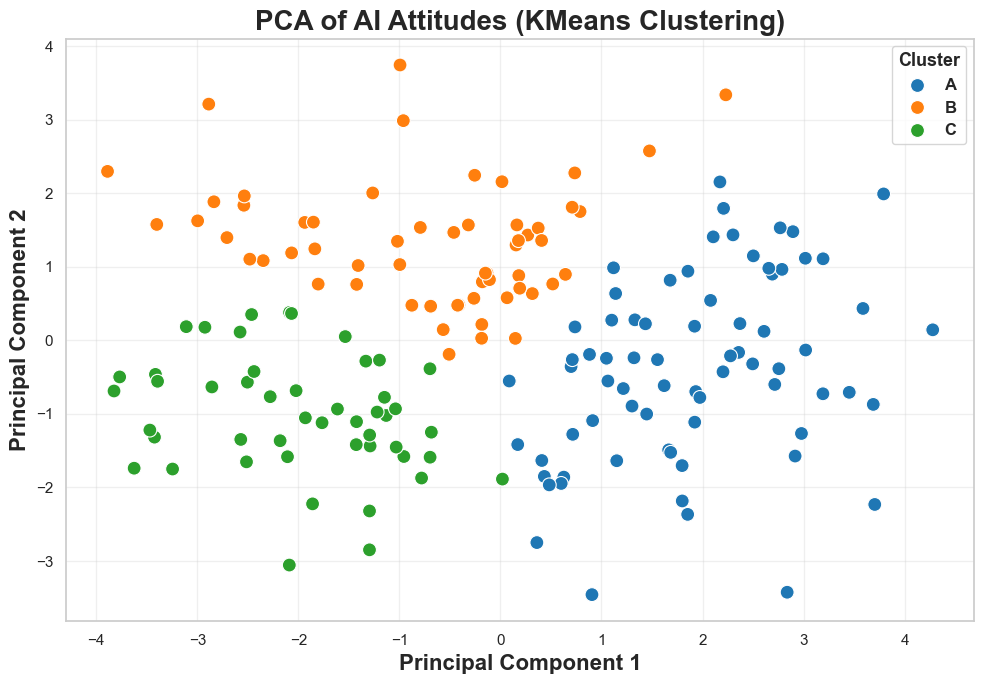

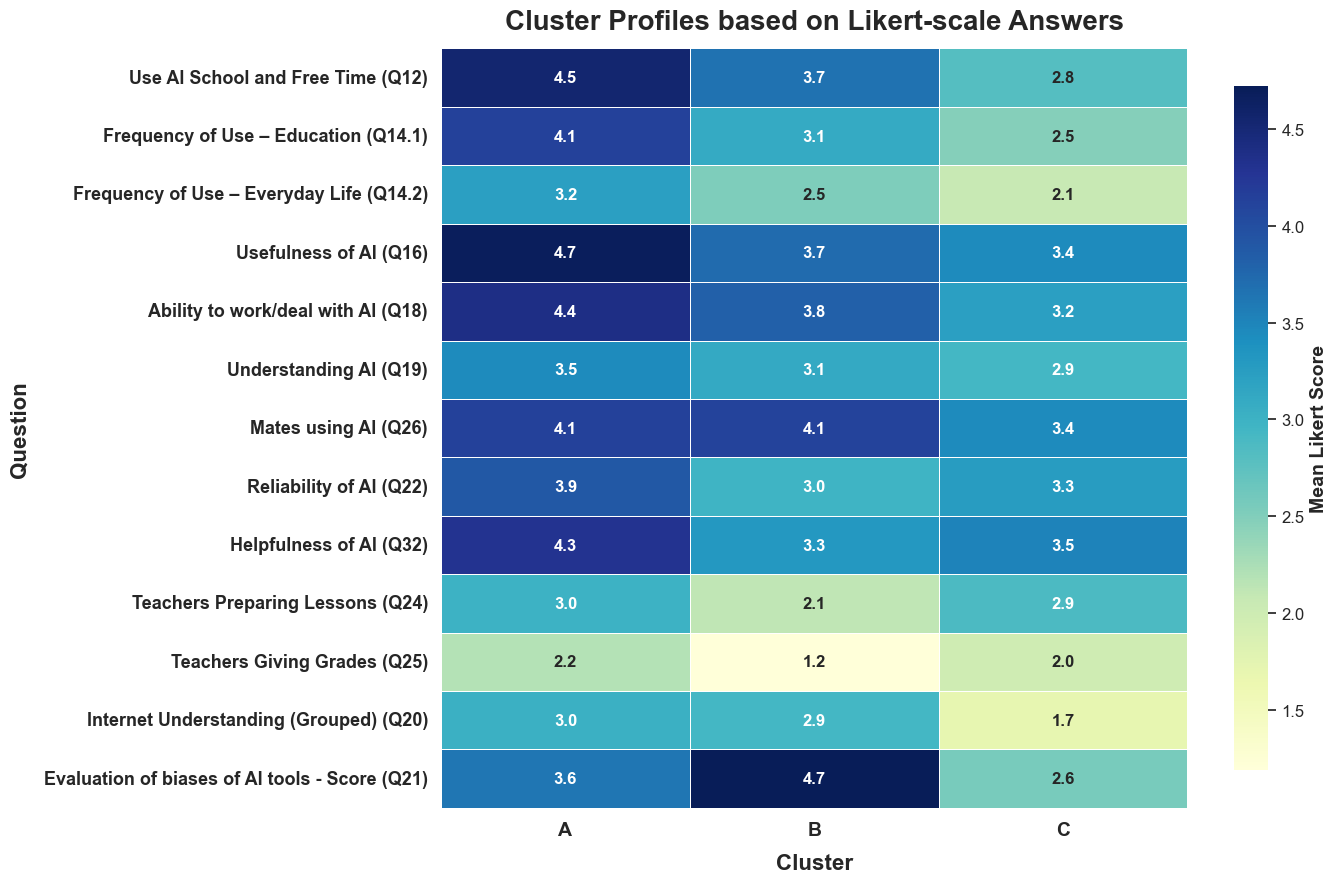

In [11]:
from pandas.api.types import CategoricalDtype

# --- KMeans & Clusterlabels (positionsbasiert, dann mappen) ---
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
clusters = kmeans.fit_predict(pca_result)

df_clean["Cluster"] = clusters                     # positionsbasiert ✓
df_plot  = pd.DataFrame(pca_result, columns=["PC1", "PC2"])
df_plot["Cluster"] = clusters

# 0→B, 1→A, 2→C
cluster_map = {0: "B", 1: "A", 2: "C"}
df_clean["Cluster"] = df_clean["Cluster"].map(cluster_map)
df_plot["Cluster"]  = df_plot["Cluster"].map(cluster_map)

# Ordnung A,B,C erzwingen
cat_type = CategoricalDtype(categories=["A", "B", "C"], ordered=True)
df_clean["Cluster"] = df_clean["Cluster"].astype(cat_type)
df_plot["Cluster"]  = df_plot["Cluster"].astype(cat_type)

# --- PCA-Scatter (größer & fett) ---
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=df_plot, x="PC1", y="PC2",
    hue="Cluster", hue_order=["A", "B", "C"],
    palette="tab10", s=100
)
plt.title("PCA of AI Attitudes (KMeans Clustering)", fontsize=20, fontweight="bold")
plt.xlabel("Principal Component 1", fontsize=16, fontweight="bold")
plt.ylabel("Principal Component 2", fontsize=16, fontweight="bold")
leg = plt.legend(title="Cluster", loc="best")
plt.setp(leg.get_texts(), fontsize=12, fontweight="bold")
plt.setp(leg.get_title(), fontsize=13, fontweight="bold")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- Cluster-Mittelwerte (Werte bleiben korrekt) ---
cluster_means = (
    df_numeric.assign(Cluster=df_clean["Cluster"])   # gleiche Index-Reihenfolge
      .groupby("Cluster", observed=True).mean()
      .reindex(["A", "B", "C"])                     # Spaltenreihenfolge fix
      .round(2)
)

# -------- Heatmap: Labels größer/fett, Zeilen umbenennbar, „Mates…“ verschieben --------
row_rename_map = {
    "Use AI school and freetime": "Use AI School and Free Time (Q12)",
    "Frequency of use education": "Frequency of Use – Education (Q14.1)",
    "Frequency of use everyday life": "Frequency of Use – Everyday Life (Q14.2)",
    "Usefullness AI": "Usefulness of AI (Q16)",
    "Deal with AI": "Ability to work/deal with AI (Q18)",
    "Understanding AI": "Understanding AI (Q19)",
    "Reliability AI": "Reliability of AI (Q22)",
    "Help of AI": "Helpfulness of AI (Q32)",
    "Mates using AI": "Mates using AI (Q26)",
    "Teachers preparing lessons": "Teachers Preparing Lessons (Q24)",
    "Teachers giving grades": "Teachers Giving Grades (Q25)",
    "Internet Understanding (Grouped)": "Internet Understanding (Grouped) (Q20)",
    "True_False_Score": "Evaluation of biases of AI tools - Score (Q21)",
}
heat_df = cluster_means.T.rename(index=row_rename_map)

# „Mates using AI“ direkt unter „Understanding AI“
name_understanding = row_rename_map.get("Understanding AI", "Understanding AI")
name_mates        = row_rename_map.get("Mates using AI", "Mates using AI")
order = list(heat_df.index)
if name_mates in order and name_understanding in order:
    order.remove(name_mates)
    order.insert(order.index(name_understanding) + 1, name_mates)
    heat_df = heat_df.loc[order]

plt.figure(figsize=(14, 9))
ax = sns.heatmap(
    heat_df[["A", "B", "C"]],
    annot=True, fmt=".1f",
    cmap="YlGnBu", linewidths=0.5,
    annot_kws={"size": 12, "weight": "bold"},
    cbar=True, cbar_kws={"shrink": 0.9}
)
plt.title("Cluster Profiles based on Likert-scale Answers", fontsize=20, fontweight="bold", pad=14)
plt.xlabel("Cluster", fontsize=16, fontweight="bold", labelpad=10)
plt.ylabel("Question", fontsize=16, fontweight="bold", labelpad=10)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, fontweight="bold", rotation=0)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=13, fontweight="bold", rotation=0)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)
cbar.set_label("Mean Likert Score", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()


In [ ]:
# ------- Analysis of the seperate clusters -------

from IPython.display import display, HTML

# files
cluster_file = os.path.join("..", "Data", "Clustered_Students.xlsx")
full_data_file = os.path.join("..", "Data", "Fertige Tabelle.xlsx")

# load data
df_total = pd.read_excel(full_data_file)
df_total.columns = df_total.columns.str.strip()


xls = pd.read_excel(cluster_file, sheet_name=None)

def _to_str_clean(s):
    #helper: drop NaN and strip
    return s.dropna().astype(str).str.strip()

def _explode_if_multiple(df, col):
    #explode MC-questions
    tmp = df[[col]].copy()
    tmp = tmp.dropna()
    if tmp[col].map(lambda x: isinstance(x, (list, tuple))).any():
        exploded = tmp.explode(col)
    else:
        exploded = tmp.assign(**{col: tmp[col].astype(str).str.split(",")}).explode(col)
    exploded[col] = exploded[col].astype(str).str.strip()
    exploded = exploded[exploded[col] != ""]
    return exploded[col]

def _apply_order(df, col):
    #sort from question order
    if col in question_orders:
        order = [str(v) for v in question_orders[col] if str(v) in df.index]
        return df.reindex(order)
    # numerical index
    if df.index.to_series().str.fullmatch(r"-?\d+(\.\d+)?").all():
        return df.sort_index(key=lambda x: x.astype(float))
    return df

# ---------- Analysis per cluster ----------
for sheet_name, cluster_df in xls.items():
    print(f"\n================  {sheet_name}  ================")

    for column in demographic_columns:
        if column not in df_total.columns:
            print(f"Spalte '{column}' nicht im Gesamtdatensatz")
            continue
        if column not in cluster_df.columns:
            print(f"Spalte '{column}' nicht im Cluster-Sheet")
            continue

        # single vs multiple choice
        if column in multiple_choice_questions:
            cluster_series = _explode_if_multiple(cluster_df, column)
            total_series   = _explode_if_multiple(df_total, column)
        else:
            cluster_series = _to_str_clean(cluster_df[column])
            total_series   = _to_str_clean(df_total[column])

        # Kategorie-Level vereinheitlichen (alle Kategorien aus total als Basis)
        total_counts = total_series.value_counts(dropna=False)
        cluster_counts = cluster_series.value_counts(dropna=False)

        # Cluster composition: % within the cluster
        cluster_comp_pct = (cluster_counts / cluster_counts.sum() * 100).reindex(total_counts.index).fillna(0).round(1)

        table_cluster_comp = pd.DataFrame({
            f"{sheet_name} Count": cluster_counts.reindex(total_counts.index).fillna(0).astype(int),
            f"{sheet_name} % (within cluster)": cluster_comp_pct
        })
        table_cluster_comp = _apply_order(table_cluster_comp, column)

        print(f"\n{column} – Distribution in {sheet_name}")
        display(HTML(table_cluster_comp.style.format(precision=1).set_caption(f"{column} – {sheet_name}: Cluster-Komposition").to_html()))
        
        # plot A
        plt.figure(figsize=(9, 4))
        sns.barplot(x=table_cluster_comp.index, y=table_cluster_comp[f"{sheet_name} % (within cluster)"], palette="Set2")
        plt.title(f"{column} – {sheet_name}: % of students in cluster")
        plt.xlabel(column)
        plt.ylabel("Prozent (%)")
        plt.xticks(rotation=45, ha="right")
        plt.ylim(0, 100)
        plt.tight_layout()
        plt.show()

        #  Category coverage of the cluster: % of the category in the cluster 
        # Share of students with category k who are in this cluster
        percent_of_category_in_cluster = (cluster_counts / total_counts * 100).reindex(total_counts.index).fillna(0).round(1)

        table_cat_capture = pd.DataFrame({
            "Total Count": total_counts.astype(int),
            f"{sheet_name} Count": cluster_counts.reindex(total_counts.index).fillna(0).astype(int),
            f"% of {column} in {sheet_name}": percent_of_category_in_cluster
        })
        table_cat_capture = _apply_order(table_cat_capture, column)

        print(f"\n{column} – % of the category in {sheet_name}:")
        display(HTML(table_cat_capture.style.format(precision=1).set_caption(f"{column} – Anteil der Kategorie im {sheet_name}").to_html()))
        
        # plot B
        plt.figure(figsize=(9, 4))
        sns.barplot(x=table_cat_capture.index, y=table_cat_capture[f"% of {column} in {sheet_name}"], palette="Set2")
        plt.title(f"{column} – % of the {column} category in {sheet_name}")
        plt.xlabel(column)
        plt.ylabel("Prozent (%)")
        plt.xticks(rotation=45, ha="right")
        plt.ylim(0, 100)
        plt.tight_layout()
        plt.show()


In [ ]:
# data from table
data = {
    "Age": [13, 14, 15, 16, 17, 18, 19],
    "Cluster A": [11.0, 9.6, 13.7, 15.1, 31.5, 12.3, 6.8],
    "Cluster B & C": [17.9, 28.3, 15.1, 18.9, 10.4, 6.6, 2.8]
}

df = pd.DataFrame(data)

# change data to seaborn format
plot_df = df.melt(id_vars="Age", var_name="Group", value_name="Percent")

# plot
plt.figure(figsize=(10, 5))
sns.barplot(data=plot_df, x="Age", y="Percent", hue="Group", palette="Set2")

plt.title("Age – Cluster A compared to Cluster B and C", fontsize=16, fontweight="bold")
plt.xlabel("Age", fontsize=14, fontweight="bold")
plt.ylabel("Percent (%)", fontsize=14, fontweight="bold")
plt.xticks(rotation=0, fontsize=12, fontweight="bold")
plt.yticks(fontsize=12, fontweight="bold")
plt.legend(title="Group", fontsize=12, title_fontsize=13, loc="best")

plt.ylim(0, 40)  # smaller scale
plt.tight_layout()
plt.show()


In [ ]:
# data from table
data = {
    "Age": [13, 14, 15, 16, 17, 18, 19],
    "Cluster B": [1.7, 20.7, 17.2, 29.3, 17.2, 8.6, 5.2],
    "Cluster A & C": [21.5, 20.7, 13.2, 11.6, 19.8, 9.1, 4.1]
}

df = pd.DataFrame(data)

# change data to seaborn format
plot_df = df.melt(id_vars="Age", var_name="Group", value_name="Percent")

# plot
plt.figure(figsize=(10, 5))
sns.barplot(data=plot_df, x="Age", y="Percent", hue="Group", palette="Set2")

plt.title("Age – Cluster B compared to Cluster A and C", fontsize=16, fontweight="bold")
plt.xlabel("Age", fontsize=14, fontweight="bold")
plt.ylabel("Percent (%)", fontsize=14, fontweight="bold")
plt.xticks(rotation=0, fontsize=12, fontweight="bold")
plt.yticks(fontsize=12, fontweight="bold")
plt.legend(title="Group", fontsize=12, title_fontsize=13, loc="best")

plt.ylim(0, 35)  #smaller scale
plt.tight_layout()
plt.show()


In [ ]:
# data from table in percentages
data = {
    "Age": [13, 14, 15, 16, 17, 18, 19],
    "Cluster C":     [37.5, 37.5, 12.5, 6.2, 2.1, 4.2, 0.0],
    "Cluster A & B": [6.9, 14.5, 15.3, 21.4, 25.2, 10.7, 6.1],
}
df = pd.DataFrame(data)

# change data to seaborn format
plot_df = df.melt(id_vars="Age", var_name="Group", value_name="Percent")

plt.figure(figsize=(10, 5))
sns.barplot(data=plot_df, x="Age", y="Percent", hue="Group", palette="Set2")

plt.title("Age – Cluster C compared to Cluster A and B", fontsize=16, fontweight="bold")
plt.xlabel("Age", fontsize=14, fontweight="bold")
plt.ylabel("Percent (%)", fontsize=14, fontweight="bold")
plt.xticks(rotation=0, fontsize=12, fontweight="bold")
plt.yticks(fontsize=12, fontweight="bold")
plt.legend(title="Group", fontsize=12, title_fontsize=13, loc="best")

plt.ylim(0, 45)  # smaller scale
plt.tight_layout()
plt.show()
